In [1]:
import numpy as np
from dataclasses import dataclass, field
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from scipy.stats import pearsonr
import seaborn as sns

Array = np.ndarray

In [2]:
def soft_threshold(x, thresh):
    """Applies element-wise soft-thresholding"""
    return np.sign(x) * np.maximum(np.abs(x) - thresh, 0.0)


def soft_threshold_offdiag(x, thresh, diag_value=1.0):
    """Soft-threshold off-diagonal only; fix diagonal to diag_value"""
    a = x.copy()
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if i != j:
                a[i, j] = np.sign(x[i, j]) * max(abs(x[i, j]) - thresh, 0.0)
            else:
                a[i, j] = diag_value
    return a


def fista_update_a(s, w, h, lambda_reg, a_init=None, num_iters=100, delta=1e-6):
    """
    FISTA update for A in the problem:
        min_A ||S - W A H.T||_F^2 + lambda * ||A||_1
    """
    n, m = s.shape
    k = w.shape[1]
    if a_init is None:
        a = np.zeros((k, k))
    else:
        a = a_init.copy()
    y = a.copy()
    t = 1.0  # step size

    wtw = w.T @ w
    hth = h.T @ h
    wts_h = w.T @ s @ h

    # Lipschitz constant can be computed from the spectral norm of the matrices
    l_w = np.linalg.norm(wtw, 2)
    l_h = np.linalg.norm(hth, 2)
    lipschitz_const = 2 * l_w * l_h
    step_size = 1.0 / lipschitz_const
    for i in range(num_iters):
        a_old = a.copy()

        # gradient of reconstruction loss at y
        grad = 2 * (wtw @ y @ hth - wts_h)

        a = soft_threshold_offdiag(y - step_size * grad, lambda_reg * step_size)

        # FISTA momentum
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = a + ((t - 1) / t_new) * (a - a_old)
        t = t_new

        if np.linalg.norm(a - a_old) < delta:
            break

    return a


def ista_update_a(s, w, h, lam, a_init=None, num_iters=100, delta=1e-6):
    """
    ISTA (proximal gradient) for:
        min_A ||S - W A H.T||_F^2 + lambda * ||A||_1
    """
    k = w.shape[1]
    if a_init is None:
        a = np.zeros((k, k))
    else:
        a = a_init.copy()
    wtw = w.T @ w
    hth = h.T @ h
    wts_h = w.T @ s @ h

    # Lipschitz constant (spectral norm)
    l_w = np.linalg.norm(wtw, 2)
    l_h = np.linalg.norm(hth, 2)
    lipschitz_const = 2 * l_w * l_h
    step_size = 1.0 / lipschitz_const
    for it in range(num_iters):
        a_old = a.copy()

        # Gradient
        grad = 2 * (wtw @ a @ hth - wts_h)

        # Gradient step + soft-thresholding
        g = a - step_size * grad
        a = soft_threshold_offdiag(g, lam * step_size)

        if np.linalg.norm(a - a_old) < delta:
            break

    return a


def update_w_nnls(s, w, h, a, alpha):
    """
    Replaces update_w with row-wise nnls solves.

    Solves: min_W ||S - W A H^T||_F^2 + alpha ||W - H||_F^2
    """
    n, r = w.shape
    sqrt_alpha = np.sqrt(alpha)

    # precompute design matrix (same for every row)
    design = np.vstack([h @ a.T, sqrt_alpha * np.eye(r)])

    w_new = np.zeros_like(w)
    for i in range(n):
        # target:   [ s[i,:]                ]
        #           [ sqrt(alpha) * h[i,:]  ]
        target = np.concatenate([s[i, :], sqrt_alpha * h[i, :]])
        wi, _ = nnls(design, target)
        w_new[i, :] = wi
    return w_new


def update_h_nnls(s, w, h, a, alpha):
    """
    Replaces update_h with row-wise nnls solves.

    Solves: min_H ||S - W A H^T||_F^2 + alpha ||H - W||_F^2
    """
    n, r = h.shape
    sqrt_alpha = np.sqrt(alpha)

    design = np.vstack([w @ a, sqrt_alpha * np.eye(r)])

    h_new = np.zeros_like(h)
    for j in range(n):
        # target:   [ s[:,j]                ]
        #           [ sqrt(alpha) * w[j,:]  ]
        target = np.concatenate([s[:, j], sqrt_alpha * w[j, :]])
        hj, _ = nnls(design, target)
        h_new[j, :] = hj
    return h_new


@dataclass(kw_only=True)
class TriFactor:
    """params:
    rank = rank of the factorization
    alpha = regularization parameter for the factorization
    lam = regularization parameter for the interaction matrix
    init = initialization method
    max_iter = maximum number of iterations
    verbose = whether to print progress
    random_state = random seed
    cd_inner = number of coordinate descent steps
    update_w = whether to update the weights
    update_h = whether to update the interaction matrix
    a_method = method for updating the interaction matrix. fixed = replaced by the a_true, identity = replaced by the identity matrix, ista = proximal gradient descent, fista = accelerated proximal gradient descent
    """

    rank: int = 10
    alpha: float = 1.0
    lam: float = 0.01
    max_iter: int = 300
    verbose: bool = False
    random_state: int | None = None
    cd_inner: int = 100
    update_w: bool = True
    update_h: bool = True

    a_method: str = "ista"
    tol: float = 1e-6
    w_true: Array | None = None
    h_true: Array | None = None
    a_true: Array | None = None

    # runtime fields (initialised at fit)
    w_: Array | None = field(init=False, default=None)
    h_: Array | None = field(init=False, default=None)
    a_: Array | None = field(init=False, default=None)
    history: dict[str, list[float]] = field(init=False, default_factory=dict)

    def fit(self, s: Array) -> "TriFactor":
        RNG = np.random.RandomState(self.random_state)
        self.w_ = 0.01 * RNG.rand(s.shape[0], self.rank)
        self.h_ = 0.01 * RNG.rand(s.shape[0], self.rank)

        if self.a_method == "fixed":
            if self.a_true is not None:
                self.a_ = self.a_true
        else:
            self.a_ = np.eye(self.rank)

        self.history = defaultdict(list)

        for it in range(self.max_iter):
            if self.update_w:
                self.w_ = update_w_nnls(s, self.w_, self.h_, self.a_, self.alpha)
            else:
                self.w_ = self.w_true
            if self.update_h:
                self.h_ = update_h_nnls(s, self.w_, self.h_, self.a_, self.alpha)
            else:
                self.h_ = self.w_  # if not we do a projection step: h = w

            # we only update a if we are not using a fixed a or identity
            if self.a_method == "ista":
                self.a_ = ista_update_a(
                    s,
                    self.w_,
                    self.h_,
                    self.lam,
                    a_init=self.a_,
                    num_iters=self.cd_inner,
                )
            elif self.a_method == "fista":
                self.a_ = fista_update_a(
                    s,
                    self.w_,
                    self.h_,
                    self.lam,
                    a_init=self.a_,
                    num_iters=self.cd_inner,
                )

            self.a_ = (self.a_ + self.a_.T) / 2

            self.s_hat_ = self.w_ @ self.a_ @ self.h_.T
            rec_error = np.linalg.norm(s - self.s_hat_, "fro") ** 2
            alpha_penalty = self.alpha * np.linalg.norm(self.w_ - self.h_, "fro") ** 2

            l1_offdiag = self.lam * np.sum(np.abs(self.a_ - np.eye(self.rank)))
            obj = rec_error + alpha_penalty + l1_offdiag
            self.history["obj"].append(obj)
            self.history["rec_error"].append(rec_error)
            self.history["alpha_penalty"].append(alpha_penalty)
            self.history["l1_offdiag"].append(l1_offdiag)

            if self.w_true is not None:
                self.history["w_diff"].append(
                    np.linalg.norm(self.w_ - self.w_true, "fro")
                )
            if self.h_true is not None:
                self.history["h_diff"].append(
                    np.linalg.norm(self.h_ - self.h_true, "fro")
                )
            if self.a_true is not None:
                self.history["a_diff"].append(
                    np.linalg.norm(self.a_ - self.a_true, "fro")
                )

            if self.verbose:
                print(
                    f"Iter {it:4d}/{self.max_iter:4d}  Obj={obj:.2f} Rec={rec_error:.2f} Alpha={alpha_penalty:.2f} L1={l1_offdiag:.2f}",
                    end="\r",
                )

        return self

    def fit_transform(self, s: Array) -> Array:
        self.fit(s)
        return self.w_

S is PSD: False | Symmetric: True
A is PSD: False | Symmetric: True


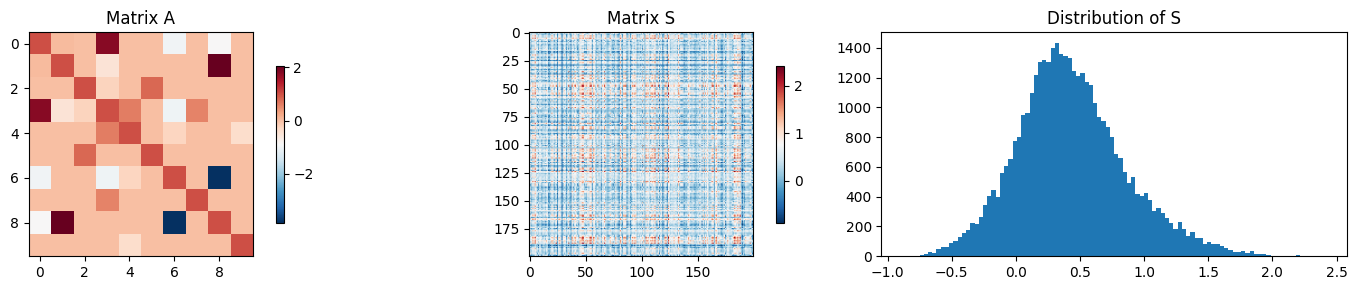

In [3]:
# Simulation setup
def make_trifactor_simulation(n, r, sparsity, random_state=42, snr=0.0):
    RNG = np.random.RandomState(random_state)
    w = 0.5 * RNG.rand(n, r)
    h = w.copy()
    a = np.eye(r)
    mask = RNG.rand(*a.shape) < sparsity
    # we make the interaction matrix a bit stronger
    a[mask] = 5 * (RNG.rand(mask.sum()) - 0.5)
    a = 0.5 * (a + a.T)

    # Bias towards negative signs by using 0.7 threshold instead of 0.5
    signs = 3 * (RNG.rand(*a.shape) > 0.7) - 1
    a = a * signs
    a = 0.5 * (a + a.T)

    s = w @ a @ h.T
    symmetric_noise = RNG.randn(*s.shape)
    symmetric_noise = (symmetric_noise + symmetric_noise.T) / 2
    s = snr * s + (1 - snr) * symmetric_noise
    return s, w, a, h


def is_psd(matrix, tol=1e-8):
    if not np.allclose(matrix, matrix.T, atol=tol):
        return False
    eigenvalues = np.linalg.eigvalsh(matrix)
    return np.all(eigenvalues >= -tol)  # allow for numerical noise


def is_symmetric(matrix, tol=1e-8):
    return np.allclose(matrix, matrix.T, atol=tol)


n, r, sparsity = 200, 10, 0.2
s, w, a, h = make_trifactor_simulation(n, r, sparsity, snr=1.0)

print("S is PSD:", is_psd(s), "| Symmetric:", is_symmetric(s))
print("A is PSD:", is_psd(a), "| Symmetric:", is_symmetric(a))
# plot each matrix separately with different sizes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
np.fill_diagonal(a, 1.0)
im1 = ax1.imshow(a, cmap="RdBu_r")
plt.colorbar(im1, ax=ax1, shrink=0.7)
ax1.set_title("Matrix A")

im2 = ax2.imshow(s, cmap="RdBu_r")
plt.colorbar(im2, ax=ax2, shrink=0.7)
ax2.set_title("Matrix S")

ax3.hist(s.flatten(), bins=100)
ax3.set_title("Distribution of S")

plt.tight_layout()
plt.show()

#### Here we now try to see if we can recover the interaction matrix a from the data. For this we fix w and h and only update a using ista or fista. 

Correlation (upper triangular only): 0.9637
Pearson correlation between w_hat and w: 1.0000 (p=0)


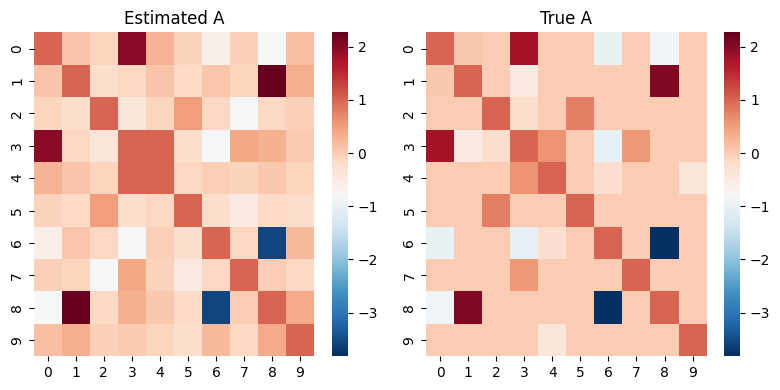

In [4]:
model = TriFactor(
    rank=r,
    alpha=1000.0,
    lam=1.0,
    verbose=False,
    cd_inner=100,
    max_iter=30,
    random_state=0,
    w_true=w,
    h_true=h,
    a_true=a,
    a_method="ista",
    update_w=False,
    update_h=False,
)
model.fit(s)
w_hat = model.w_
h_hat = model.h_
a_hat = model.a_
history = model.history


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
vmin = min(a_hat.min(), a.min())
vmax = max(a_hat.max(), a.max())
sns.heatmap(a_hat, cmap="RdBu_r", ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title("Estimated A")
sns.heatmap(a, cmap="RdBu_r", ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title("True A")
plt.tight_layout()
# Get upper triangular elements only
a_upper = np.triu(a)
a_hat_upper = np.triu(a_hat)
# Calculate correlation between upper triangular elements
corr = np.corrcoef(a_upper.flatten(), a_hat_upper.flatten())[0, 1]
print(f"Correlation (upper triangular only): {corr:.4f}")

# Correlate w_hat with w and print Pearson correlation
pearson_corr, pearson_p = pearsonr(w_hat.flatten(), w.flatten())
print(
    f"Pearson correlation between w_hat and w: {pearson_corr:.4f} (p={pearson_p:.2g})"
)

### Here we now fix the interaction matrix and only update w and set h=w using a projectio step after each iteration. We can see that we cannot recover W using this

In [5]:
model = TriFactor(
    rank=r,
    alpha=1000.0,
    lam=1.0,
    verbose=True,
    cd_inner=100,
    max_iter=100,
    random_state=0,
    w_true=w,
    h_true=h,
    a_true=a,
    a_method="fixed",  # if fixed A is set to A_true and not uodated
    update_w=True,
    update_h=False,
)
model.fit(s)
w_hat = model.w_
h_hat = model.h_
a_hat = model.a_
history = model.history
# correlate w and h using pearson
pearson_corr, pearson_p = pearsonr(w_hat.flatten(), w.flatten())
print(
    f"Pearson correlation between w_hat and w: {pearson_corr:.4f} (p={pearson_p:.2g})"
)

Pearson correlation between w_hat and w: 0.0733 (p=0.001)7676


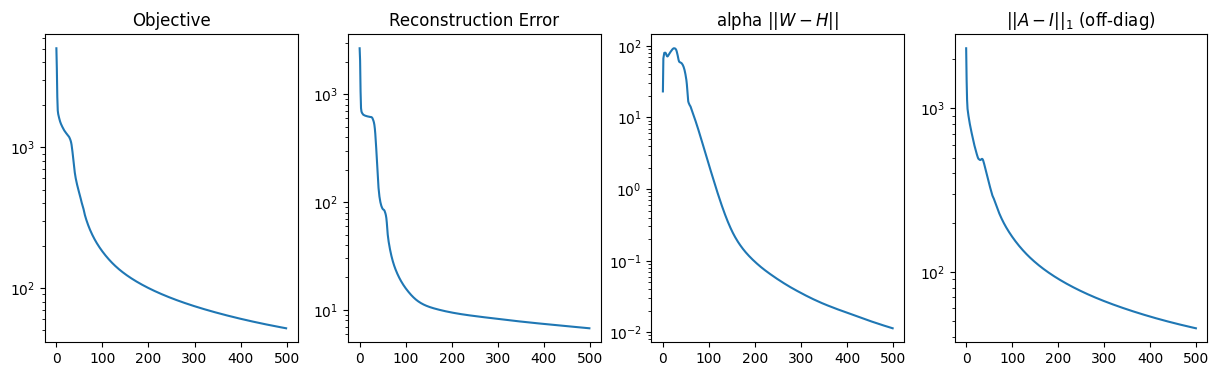

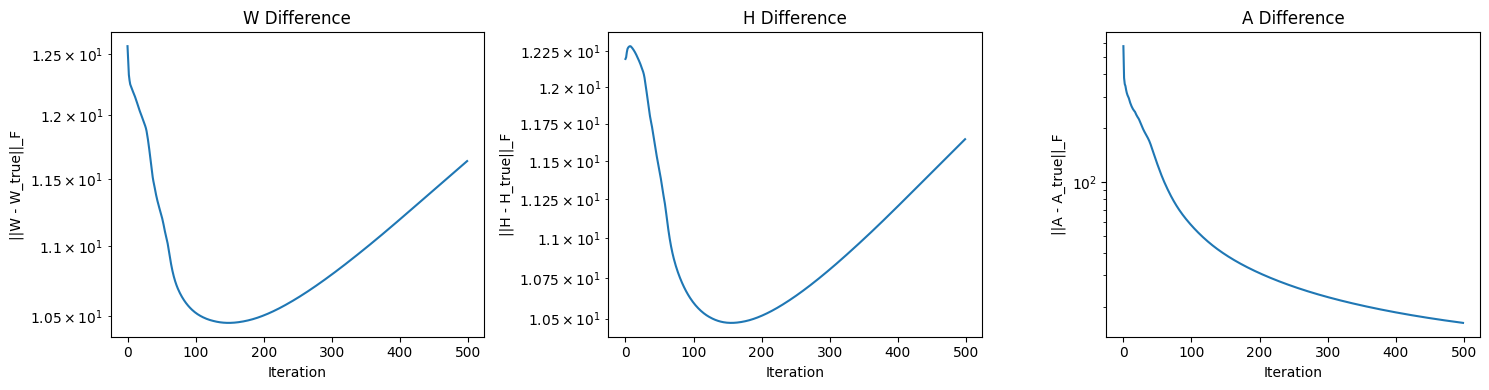

In [7]:
#### NOw we update everything to see what we can do in terms of convergence

model = TriFactor(
    rank=r,
    alpha=100.0,
    lam=1.0,
    verbose=True,
    cd_inner=100,
    max_iter=500,
    random_state=0,
    w_true=w,
    h_true=h,
    a_true=a,
    a_method="fista",
    update_w=True,
    update_h=True,
)
model.fit(s)
history = model.history

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].semilogy(history["obj"])
axes[0].set_title("Objective")
axes[1].semilogy(history["rec_error"])
axes[1].set_title("Reconstruction Error")
axes[2].semilogy(history["alpha_penalty"])
axes[2].set_title(r"alpha $||W- H||$")
axes[3].semilogy(history["l1_offdiag"])
axes[3].set_title(r"$||A - I||_1$ (off-diag)")
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].semilogy(history["w_diff"])
axes[0].set_title("W Difference")
axes[1].semilogy(history["h_diff"])
axes[1].set_title("H Difference")
axes[2].semilogy(history["a_diff"])
axes[2].set_title("A Difference")

axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("||W - W_true||_F")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("||H - H_true||_F")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("||A - A_true||_F")
plt.tight_layout()
plt.show()